# Section 9b: Planar III-V epoxy-bonded to textured Si

The structure in this example is based on that of
[the previous example (9a)](9a-GaInP_GaAs_Si_grating.ipynb), but
with the planar bottom Si cell replaced by a Si cell with a pyramidal texture, bonded
 to the III-V top cells with a low-index epoxy/glass layer.

We could use the angular redistribution matrix method as in the previous example -
however, because in this example we only need to use TMM and ray-tracing (RT), we can
 use the ray-tracing method with integrated RT directly (this is generally faster,
 because we do not need to calculate the behaviour of the surfaces for every angle of
  incidence).

## Setting up

We load relevant packages and define materials, the same as in the previous example.

In [19]:
#| output: false

from solcore import material, si
from solcore.absorption_calculator import search_db, download_db
import os
from solcore.structure import Layer
from solcore.light_source import LightSource
from rayflare.ray_tracing import rt_structure
from rayflare.transfer_matrix_method import tmm_structure
from rayflare.textures import planar_surface, regular_pyramids
from rayflare.options import default_options
from solcore.constants import q
import numpy as np
import matplotlib.pyplot as plt

# download_db()

In [20]:
MgF2_pageid = search_db(os.path.join("MgF2", "Rodriguez-de Marcos"))[0][0];
Ta2O5_pageid = search_db(os.path.join("Ta2O5", "Rodriguez-de Marcos"))[0][0];
SU8_pageid = search_db("SU8")[0][0];
Ag_pageid = search_db(os.path.join("Ag", "Jiang"))[0][0];

epoxy = material("BK7")()

MgF2 = material(str(MgF2_pageid), nk_db=True)();
Ta2O5 = material(str(Ta2O5_pageid), nk_db=True)();
SU8 = material(str(SU8_pageid), nk_db=True)();
Ag = material(str(Ag_pageid), nk_db=True)();

window = material("AlInP")(Al=0.52)
GaInP = material("GaInP")
AlGaAs = material("AlGaAs")

Air = material("Air")()

GaAs = material("GaAs")

Si = material("Si")

Al2O3 = material("Al2O3P")()
Al = material("Al")()

Database file found at /Users/z3533914/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
234	main	MgF2	Rodriguez-de_Marcos	main/MgF2/Rodriguez-de Marcos.yml	1	1	0.0299919	2.00146	960
Database file found at /Users/z3533914/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
475	main	Ta2O5	Rodriguez-de_Marcos	main/Ta2O5/Rodriguez-de Marcos.yml	1	1	0.0294938	1.51429	212
Database file found at /Users/z3533914/.solcore/nk/nk.db
2 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
2835	other	negative_tone_photoresists	Microchem_SU8_2000	other/resists/Microchem SU-8 2000.yml	1	0	0.32	0.8	200
2836	other	negative_tone_photoresists	Microchem_SU8_3000	other/resists/Microchem SU-8 3000.yml	1	0	0.32	1.7	200
Database file found at /Users/z3533914/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	has

We define the layers we will need, as before. We specify the thickness of the silicon
 (280 $\mu$m)
 and epoxy (1 mm) at the top:

In [21]:
d_Si = 280e-6 # thickness of Si wafer
d_epoxy = 1e-6 # thickness of epoxy. In reality, the epoxy is much thicker, but the exact thickness doesn't matter 
               # because the material is transparent and we will treat it incoherently.

GaInP_total_thickness = 350e-9
GaAs_total_thickness = 1200e-9

ARC = [Layer(110e-9, MgF2), Layer(65e-9, Ta2O5)]

GaInP_junction = [Layer(20e-9, window), Layer(GaInP_total_thickness, GaInP(In=0.50))]

# 100 nm TJ
tunnel_1 = [Layer(100e-9, AlGaAs(Al=0.8)), Layer(20e-9, GaInP(In=0.5))]

GaAs_junction = [Layer(20e-9, GaInP(In=0.5)), Layer(GaAs_total_thickness, GaAs()), Layer(70e-9, AlGaAs(Al=0.8))]

spacer_ARC = [Layer(80e-9, Ta2O5)]

## Defining the cell layers

There are three interfaces in the cell which will define the structure to simulate:

1. the III-V/epoxy interface, where the epoxy itself will be treated as a bulk layer in
   the simulation
2. the epoxy/Si interface, where the Si has a pyramidal texture (the Si itself is
   another bulk layer in the simulation).
3. the rear surface of the cell, where the Si again has a pyramidal texture (and we
   assume there is a silver back mirror behind the cell)

These 3 interfaces are defined here, using the pre-defined textures for a planar
surface or regular pyramids:

In [22]:
front_layers = ARC + GaInP_junction + tunnel_1 + GaAs_junction + spacer_ARC

front_surf = planar_surface(interface_layers = front_layers, prof_layers=np.arange(1, len(front_layers)+1))

Si_front = regular_pyramids(elevation_angle=50, upright=True)

Si_back = regular_pyramids(elevation_angle=50, upright=False)

Now we set relevant options for the solver. We set the number of rays to trace at
each wavelength (more rays will make the result less noisy, but increase computation
time) and whether to calculate the absorption profile in the bulk layers (no, in this
case). The `randomize_surface` options determines whether the ray keeps track of its
positions in the unit cell while travelling between surfaces; we set this to `False` to
 mimic random pyramids.

In [23]:
options = default_options()

wl = np.arange(300, 1201, 10) * 1e-9
AM15G = LightSource(source_type="standard", version="AM1.5g", x=wl, output_units="photon_flux_per_m")

options.wavelength = wl
options.project_name = "III_V_Si_cell"

# options for ray-tracing
options.randomize_surface = True
options.n_rays = 1000
options.bulk_profile = False

## Defining the structures

Finally, we define the ray-tracing structure we will use, using the interfaces, bulk
materials, and options set above. Because we want to calculate the
reflection/absorption/transmission probabilities at the front surface using TMM, we
set the `use_TMM` argument to True. We also define a completely planar cell with the
same layer thicknesses etc. to compare and evaluate the effect of the textures Si
surfaces.

In [24]:
optical_structure = rt_structure(
    textures=[front_surf, Si_front, Si_back],
    materials=[epoxy, Si()],
    widths=[d_epoxy, d_Si],
    incidence=Air,
    transmission=Ag,
    options=options,
    use_TMM=True,
    save_location="current", # lookup table save location
    overwrite=True, # whether to overwrite any previously existing results, if found
)

# options for TMM
options.coherent = False
options.coherency_list = len(front_layers)*['c'] + ['i']*2

planar_optical_structure = tmm_structure(
    layer_stack = front_layers + [Layer(d_epoxy, epoxy), Layer(d_Si, Si())],
    incidence=Air,
    transmission=Ag,
)

INFO: Pre-computing TMM lookup table(s)


Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.


## Calculations

Calculate the R/A/T for the planar reference cell:

In [25]:
#| output: false

tmm_result = planar_optical_structure.calculate(options=options)

GaInP_A_tmm = tmm_result['A_per_layer'][:,3]
GaAs_A_tmm = tmm_result['A_per_layer'][:,7]
Si_A_tmm = tmm_result['A_per_layer'][:,len(front_layers)+1]

Jmax_GaInP_tmm = q*np.trapz(GaInP_A_tmm*AM15G.spectrum()[1], x=wl)/10
Jmax_GaAs_tmm = q*np.trapz(GaAs_A_tmm*AM15G.spectrum()[1], x=wl)/10
Jmax_Si_tmm = q*np.trapz(Si_A_tmm*AM15G.spectrum()[1], x=wl)/10

Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.


Calculate the R/A/T for the textured cell:

In [26]:
#| output: false

rt_result = optical_structure.calculate(options=options)

GaInP_absorption_ARC = rt_result['A_per_interface'][0][:,3]
GaAs_absorption_ARC = rt_result['A_per_interface'][0][:,7]
Si_absorption_ARC = rt_result['A_per_layer'][:,1]

Jmax_GaInP = q*np.trapz(GaInP_absorption_ARC*AM15G.spectrum()[1], x=wl)/10
Jmax_GaAs = q*np.trapz(GaAs_absorption_ARC*AM15G.spectrum()[1], x=wl)/10
Jmax_Si = q*np.trapz(Si_absorption_ARC*AM15G.spectrum()[1], x=wl)/10

INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
I

INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
I

## Plotting the results

Finally, we plot the results; the solid lines show the results for the textured Si
cell (calculated using ray-tracing), the dashed lines for the planar cell (calculated
 using TMM). The maximum possible currents are shown in the plot, with the value in
 brackets for Si being for the planar cell.

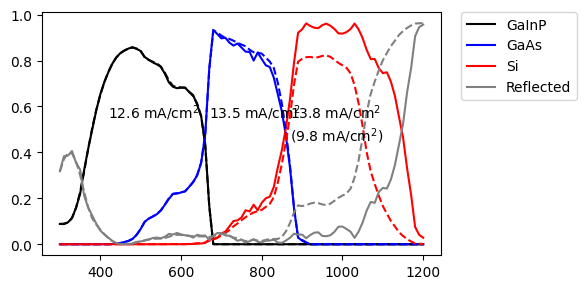

In [27]:
plt.figure(figsize=(6,3))
plt.plot(wl * 1e9, GaInP_absorption_ARC, "-k", label="GaInP")
plt.plot(wl * 1e9, GaAs_absorption_ARC, "-b", label="GaAs")
plt.plot(wl * 1e9, Si_absorption_ARC, "-r", label="Si")
plt.plot(wl * 1e9, GaInP_A_tmm, "--k")
plt.plot(wl * 1e9, GaAs_A_tmm, "--b")
plt.plot(wl * 1e9, Si_A_tmm, "--r")
plt.plot(wl * 1e9, rt_result['R'], '-', color='grey', label="Reflected")
plt.plot(wl * 1e9, tmm_result['R'], '--', color='grey')

plt.text(420, 0.55, r"{:.1f} mA/cm$^2$".format(Jmax_GaInP))
plt.text(670, 0.55, r"{:.1f} mA/cm$^2$".format(Jmax_GaAs))
plt.text(870, 0.55, r"{:.1f} mA/cm$^2$".format(Jmax_Si))
plt.text(870, 0.45, r"({:.1f} mA/cm$^2)$".format(Jmax_Si_tmm))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

## Questions/challenges

- Does it make sense to do a ray-tracing calculation for short wavelengths? For this
  structure, can you speed up the calculation and avoid the random noise at short
  wavelengths?
- How much current is lost to parasitic absorption in e.g. tunnel junctions, window
  layers etc.?
- How can we reduce reflection at the epoxy interfaces?
- If the epoxy/glass layer is much thicker than the relevant incident wavelengths,
  and not absorbing, does the exact thickness matter in the simulation?
- What happens if only the rear surface is textured? Would a structure without the
  front texture have other advantages?
- Why does the Si have lower absorption/limiting current in this structure compared to
  the [previous example](9a-GaInP_GaAs_Si_grating.ipynb)?

Now we can also use RayFlare's optical results to run an electrical simulation in Solcore. To use the depletion approximation (DA) or drift-diffusion (PDD) solvers, we need the front surface reflectivity, and a depth-dependent absorption/generation profile. While so far we have been plotting total absorption per layer, RayFlare can calculate depth-dependent profiles too.

In [28]:
from solcore.solar_cell import SolarCell, Junction
from solcore.solar_cell_solver import solar_cell_solver
from rayflare.utilities import make_absorption_function
from solcore.state import State

options = State(options) # convert to Solcore options object so Solcore will recognise it
V = np.linspace(-3, 0, 100)

options.bulk_profile = True
options.depth_spacing = 1e-9
options.depth_spacing_bulk = 10e-9
options.optics_method = 'external'
options.voltages = V
options.internal_voltages = np.linspace(-4, 1, 200)
options.light_iv = True
options.mpp = True
options.light_source = AM15G
options.recalculate_absorption = True

profile_data = optical_structure.calculate_profile(options)

depths, external_optics_func = make_absorption_function(profile_data, optical_structure, options)

options.position = depths

INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
I

INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...


INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...


INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...


Previously, we defined RayFlare `rt_structure` and `tmm_structure` objects to do the optical calculation. For the cell calculation, we need a Solcore `SolarCell` object, which needs different information (such as doping levels) to perform the electrical calculation.

In [29]:
GaInP_emitter_thickness = 100e-9
GaAs_emitter_thickness = 200e-9
Si_emitter_thickness = 1e-6

GaInP_base_thickness = GaInP_total_thickness - GaInP_emitter_thickness
GaAs_base_thickness = GaAs_total_thickness - GaAs_emitter_thickness
Si_base_thickness = d_Si - Si_emitter_thickness

GaInP_junction = Junction([
    Layer(20e-9, material("AlInP")(Al=0.52), Nd=si("1e18cm-3"), role="window"), # window
    Layer(GaInP_emitter_thickness, GaInP(In=0.50, Nd=si("1e18cm-3"), hole_diffusion_length=si("200nm")), role="emitter"), # emitter
    Layer(GaInP_base_thickness, GaInP(In=0.50, Na=si("1e17cm-3"), electron_diffusion_length=si("300nm")), role="base"), # base
   ], kind="DA") # TJ

GaAs_junction = Junction([
    Layer(20e-9, GaInP(In=0.5, Nd=si("1e18cm-3")), role="window"), # window
    Layer(GaAs_emitter_thickness, GaAs(Nd=si("1e18cm-3"), hole_diffusion_length=si("250nm")), role="emitter"), # emitter
    Layer(GaAs_base_thickness, GaAs(Na=si("9e16cm-3"), electron_diffusion_length=si("1000nm")), role="base"), # basee
    Layer(70e-9, AlGaAs(Al=0.8, Na=si("4e18cm-3")), role="bsf") # BSF
    ], kind="DA")

Si_junction = Junction([
    Layer(Si_emitter_thickness, Si(Nd=si("1e19cm-3"), hole_diffusion_length=si("1000nm")), role="emitter"),
    Layer(Si_base_thickness, Si(Na=si("1e16cm-3"), electron_diffusion_length=si("250um")), role="base")],
    kind="DA")

solar_cell = SolarCell(
    ARC + [GaInP_junction] + tunnel_1 + [GaAs_junction] + spacer_ARC + [Layer(d_epoxy, epoxy)] + [Si_junction],
    external_reflected=rt_result["R"],
    external_absorbed=external_optics_func)

INFO: Solving optics of the solar cell...


Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


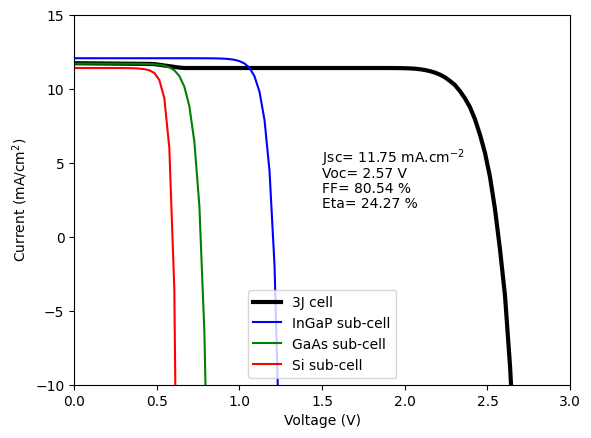

In [36]:
solar_cell_solver(solar_cell, 'iv', options)

plt.figure(2)
plt.plot(-V, -solar_cell.iv['IV'][1]/10, 'k', linewidth=3, label='3J cell')
plt.plot(-V, solar_cell(0).iv(V)/10, 'b', label='InGaP sub-cell')
plt.plot(-V, solar_cell(1).iv(V)/10, 'g', label='GaAs sub-cell')
plt.plot(-V, solar_cell(2).iv(V)/10, 'r', label='Si sub-cell')
plt.text(1.5, 5,f'Jsc= {abs(solar_cell.iv.Isc/10):.2f} mA.cm' + r'$^{-2}$')
plt.text(1.5, 4,f'Voc= {abs(solar_cell.iv.Voc):.2f} V')
plt.text(1.5, 3,f'FF= {solar_cell.iv.FF*100:.2f} %')
plt.text(1.5, 2,f'Eta= {solar_cell.iv.Eta*100:.2f} %')

plt.legend()
plt.ylim(-10, 15)
plt.xlim(0, 3)
plt.ylabel('Current (mA/cm$^2$)')
plt.xlabel('Voltage (V)')
plt.show()

In [31]:
V

array([-3.        , -2.96969697, -2.93939394, -2.90909091, -2.87878788,
       -2.84848485, -2.81818182, -2.78787879, -2.75757576, -2.72727273,
       -2.6969697 , -2.66666667, -2.63636364, -2.60606061, -2.57575758,
       -2.54545455, -2.51515152, -2.48484848, -2.45454545, -2.42424242,
       -2.39393939, -2.36363636, -2.33333333, -2.3030303 , -2.27272727,
       -2.24242424, -2.21212121, -2.18181818, -2.15151515, -2.12121212,
       -2.09090909, -2.06060606, -2.03030303, -2.        , -1.96969697,
       -1.93939394, -1.90909091, -1.87878788, -1.84848485, -1.81818182,
       -1.78787879, -1.75757576, -1.72727273, -1.6969697 , -1.66666667,
       -1.63636364, -1.60606061, -1.57575758, -1.54545455, -1.51515152,
       -1.48484848, -1.45454545, -1.42424242, -1.39393939, -1.36363636,
       -1.33333333, -1.3030303 , -1.27272727, -1.24242424, -1.21212121,
       -1.18181818, -1.15151515, -1.12121212, -1.09090909, -1.06060606,
       -1.03030303, -1.        , -0.96969697, -0.93939394, -0.90

INFO: Solving optics of the solar cell...


Solving QE of the solar cell...


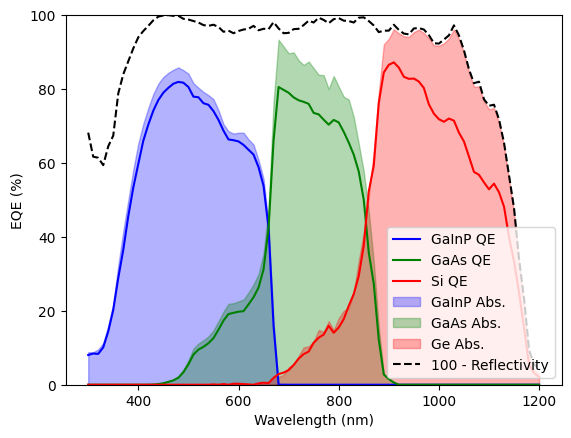

In [32]:

solar_cell_solver(solar_cell, 'qe', options)

plt.figure(1)
plt.plot(wl * 1e9, solar_cell(0).eqe(wl) * 100, 'b', label='GaInP QE')
plt.plot(wl * 1e9, solar_cell(1).eqe(wl) * 100, 'g', label='GaAs QE')
plt.plot(wl * 1e9, solar_cell(2).eqe(wl) * 100, 'r', label='Si QE')
plt.fill_between(wl * 1e9, GaInP_absorption_ARC * 100, 0, alpha=0.3,
         label='GaInP Abs.', color='b')
plt.fill_between(wl * 1e9, GaAs_absorption_ARC * 100, 0, alpha=0.3,
         label='GaAs Abs.', color='g')
plt.fill_between(wl * 1e9, Si_absorption_ARC * 100, 0, alpha=0.3,
         label='Ge Abs.', color='r')

plt.plot(wl*1e9, 100*(1-solar_cell.reflected), '--k', label="100 - Reflectivity")
plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')
plt.show()
